#  Predicting Bayern Munich’s League Wins (2008–2016)

This project uses the **European Soccer Database (2008–2016)** to analyze and predict whether **FC Bayern Munich** would win the league in a given season.

We extract Bayern’s matches, calculate their performance statistics (goals, wins, losses, etc.), merge them with **team attributes from FIFA data**, and train a **Random Forest Classifier** to predict league victory.


## Import Libraries

In [ ]:
import pandas as pd              
import numpy as np               
import seaborn as sns            
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV 
from sklearn.pipeline import make_pipeline         
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC                          
from sklearn.neighbors import KNeighborsClassifier    
from sklearn.metrics import accuracy_score, classification_report  

## Load Data

In [5]:
import pandas as pd

matches = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\Match.csv")
teams = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\Team.csv")
team_attr = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\Team_Attributes.csv")
country = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\Country.csv")
league = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\League.csv")


print(matches.head())
print(teams.head())
print(team_attr.head())


   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492475              9984              8635               0  ...   
3        492476              9991              9998               5  ...   
4        492477              7947              9985               1  ...   

    SJA   VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  4.00  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3

## Clean Data

In [7]:
print(league.isna().sum())
print(matches.isna().sum())
print(country.isna().sum())
print(teams.isna().sum())
print(matches.isna().sum())


id            0
country_id    0
name          0
dtype: int64
id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64
id      0
name    0
dtype: int64
id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64
id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64


In [8]:
teams['team_fifa_api_id'].fillna(teams['team_fifa_api_id'].mean(), inplace=True)


C:\Users\zakih\AppData\Local\Temp\ipykernel_50808\3019240060.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  teams['team_fifa_api_id'].fillna(teams['team_fifa_api_id'].mean(), inplace=True)


In [9]:
matches = matches.drop(columns=['SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA'])


In [10]:
cols_to_keep = ['team_api_id','date','buildUpPlaySpeed','buildUpPlayDribbling',
                'buildUpPlayPassing','chanceCreationPassing','chanceCreationShooting',
                'defencePressure','defenceAggression','defenceTeamWidth']
team_attr_clean = team_attr[cols_to_keep]


In [11]:
matches['date'] = pd.to_datetime(matches['date'])
team_attr_clean['date'] = pd.to_datetime(team_attr_clean['date'])


C:\Users\zakih\AppData\Local\Temp\ipykernel_50808\3093553028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_attr_clean['date'] = pd.to_datetime(team_attr_clean['date'])


In [ ]:
import pandas as pd

teams = pd.read_csv(r"C:\Users\zakih\OneDrive\Desktop\projects\European Soccer Database\Team.csv")


team_names = teams[['team_api_id','team_long_name','team_short_name']]
print(team_names.head(20))  
unique_team_names = teams['team_long_name'].unique()
print(unique_team_names)


    team_api_id        team_long_name team_short_name
0          9987              KRC Genk             GEN
1          9993          Beerschot AC             BAC
2         10000      SV Zulte-Waregem             ZUL
3          9994      Sporting Lokeren             LOK
4          9984     KSV Cercle Brugge             CEB
5          8635        RSC Anderlecht             AND
6          9991              KAA Gent             GEN
7          9998             RAEC Mons             MON
8          7947         FCV Dender EH             DEN
9          9985     Standard de Liège             STL
10         8203           KV Mechelen             MEC
11         8342        Club Brugge KV             CLB
12         9999         KSV Roeselare             ROS
13         8571           KV Kortrijk             KOR
14         4049                Tubize             TUB
15         9996  Royal Excel Mouscron             MOU
16        10001          KVC Westerlo             WES
17         9986    Sporting 

## Filter Bayern Munich Matches

In [13]:
bayern = teams[teams['team_long_name'] == 'FC Bayern Munich']
print(bayern)


       id  team_api_id  team_fifa_api_id    team_long_name team_short_name
94  15617         9823              21.0  FC Bayern Munich             BMU


In [15]:
bayern_id = 9823

bayern_matches = matches[(matches['home_team_api_id'] == bayern_id) | 
                         (matches['away_team_api_id'] == bayern_id)]
print(bayern_matches.head())


        id  country_id  league_id     season  stage       date  match_api_id  \
7808  7809        7809       7809  2008/2009      1 2008-08-15        499317   
7821  7822        7809       7809  2008/2009     10 2008-10-29        499402   
7826  7827        7809       7809  2008/2009     11 2008-11-01        499407   
7837  7838        7809       7809  2008/2009     12 2008-11-09        499418   
7851  7852        7809       7809  2008/2009     13 2008-11-15        499432   

      home_team_api_id  away_team_api_id  home_team_goal  ...   LBD    LBA  \
7808              9823              9790               2  ...  3.50   5.50   
7821              9810              9823               1  ...  3.50   1.53   
7826              9823              9912               3  ...  5.00  11.00   
7837             10189              9823               1  ...  3.20   2.38   
7851              9788              9823               2  ...  3.75   1.44   

      PSH  PSD  PSA   WHH  WHD    WHA   SJH   SJD 

## Season Summary

In [ ]:
bayern_matches = bayern_matches.copy()  

bayern_matches['goals_scored'] = bayern_matches.apply(
    lambda row: row['home_team_goal'] if row['home_team_api_id']==bayern_id else row['away_team_goal'], axis=1)

bayern_matches['goals_conceded'] = bayern_matches.apply(
    lambda row: row['away_team_goal'] if row['home_team_api_id']==bayern_id else row['home_team_goal'], axis=1)

def match_result(row):
    if row['home_team_api_id'] == bayern_id:
        if row['home_team_goal'] > row['away_team_goal']:
            return 'W'
        elif row['home_team_goal'] == row['away_team_goal']:
            return 'D'
        else:
            return 'L'
    else:
        if row['away_team_goal'] > row['home_team_goal']:
            return 'W'
        elif row['away_team_goal'] == row['home_team_goal']:
            return 'D'
        else:
            return 'L'

bayern_matches['result'] = bayern_matches.apply(match_result, axis=1)

season_stats = bayern_matches.groupby('season').agg(
    goals_scored=('goals_scored','sum'),
    goals_conceded=('goals_conceded','sum'),
    wins=('result', lambda x: (x=='W').sum()),
    draws=('result', lambda x: (x=='D').sum()),
    losses=('result', lambda x: (x=='L').sum()),
    matches_played=('result','count')
).reset_index()

print(season_stats)


      season  goals_scored  goals_conceded  wins  draws  losses  \
0  2008/2009            71              42    20      7       7   
1  2009/2010            72              31    20     10       4   
2  2010/2011            81              40    19      8       7   
3  2011/2012            77              22    23      4       7   
4  2012/2013            98              18    29      4       1   
5  2013/2014            94              23    29      3       2   
6  2014/2015            80              18    25      4       5   
7  2015/2016            80              17    28      4       2   

   matches_played  
0              34  
1              34  
2              34  
3              34  
4              34  
5              34  
6              34  
7              34  


## Merge with Team Attributes

In [18]:
bayern_attr = team_attr_clean[team_attr_clean['team_api_id'] == bayern_id].copy()


In [ ]:
bayern_attr['date'] = pd.to_datetime(bayern_attr['date'])

bayern_attr['season'] = bayern_attr['date'].dt.year.astype(str) + '/' + (bayern_attr['date'].dt.year + 1).astype(str)


In [20]:
season_attr = bayern_attr.groupby('season').mean().reset_index()


In [ ]:
numeric_cols = ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing',
                'chanceCreationPassing','chanceCreationShooting','defencePressure',
                'defenceAggression','defenceTeamWidth']

for col in numeric_cols:
    bayern_data[col] = bayern_data[col].fillna(bayern_data[col].mean())

print(bayern_data)


      season  goals_scored  goals_conceded  wins  draws  losses  \
0  2008/2009            71              42    20      7       7   
1  2009/2010            72              31    20     10       4   
2  2010/2011            81              40    19      8       7   
3  2011/2012            77              22    23      4       7   
4  2012/2013            98              18    29      4       1   
5  2013/2014            94              23    29      3       2   
6  2014/2015            80              18    25      4       5   
7  2015/2016            80              17    28      4       2   

   matches_played  team_api_id       date  buildUpPlaySpeed  \
0              34          NaN        NaT         48.666667   
1              34          NaN        NaT         48.666667   
2              34       9823.0 2010-02-22         65.000000   
3              34       9823.0 2011-02-22         42.000000   
4              34       9823.0 2012-02-22         47.000000   
5              34 

## Create Target Variable

In [ ]:
bayern_wins = ['2012/2013','2013/2014','2014/2015','2015/2016']

bayern_data['won_cup'] = bayern_data['season'].apply(lambda x: 1 if x in bayern_wins else 0)

print(bayern_data)


      season  goals_scored  goals_conceded  wins  draws  losses  \
0  2008/2009            71              42    20      7       7   
1  2009/2010            72              31    20     10       4   
2  2010/2011            81              40    19      8       7   
3  2011/2012            77              22    23      4       7   
4  2012/2013            98              18    29      4       1   
5  2013/2014            94              23    29      3       2   
6  2014/2015            80              18    25      4       5   
7  2015/2016            80              17    28      4       2   

   matches_played  team_api_id       date  buildUpPlaySpeed  \
0              34          NaN        NaT         48.666667   
1              34          NaN        NaT         48.666667   
2              34       9823.0 2010-02-22         65.000000   
3              34       9823.0 2011-02-22         42.000000   
4              34       9823.0 2012-02-22         47.000000   
5              34 

## Train Model

In [ ]:

X = bayern_data.drop(columns=['season','team_api_id','date','won_cup'])
y = bayern_data['won_cup']


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = rf_model.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[1 0]
 [0 1]]


## Feature Importance Visualization

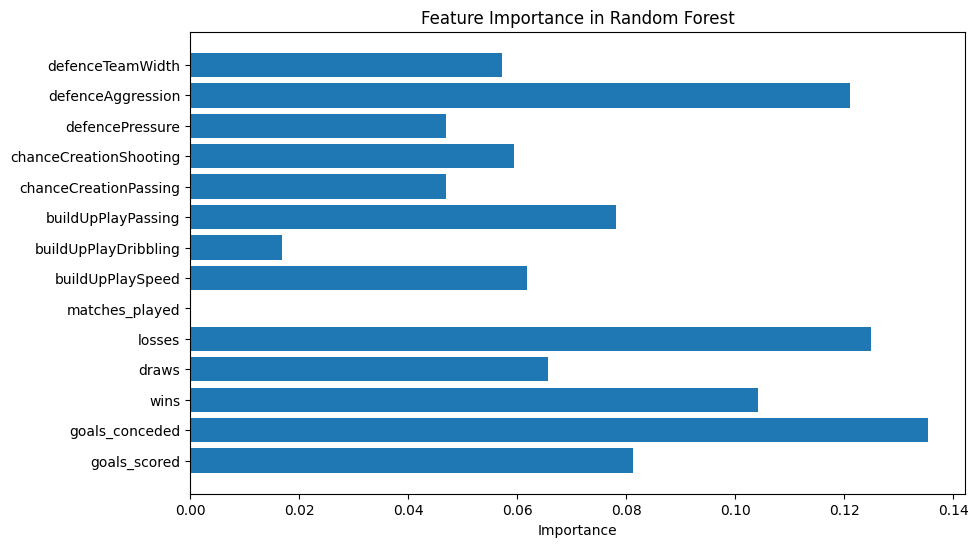

In [ ]:
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()


In [32]:
import pandas as pd

future_bayern = pd.DataFrame({
    'goals_scored': [90],
    'goals_conceded': [20],
    'wins': [27],
    'draws': [5],
    'losses': [2],
    'matches_played': [34],
    'buildUpPlaySpeed': [50],
    'buildUpPlayDribbling': [40],
    'buildUpPlayPassing': [45],
    'chanceCreationPassing': [60],
    'chanceCreationShooting': [70],
    'defencePressure': [50],
    'defenceAggression': [45],
    'defenceTeamWidth': [55]
})


In [ ]:
prediction = rf_model.predict(future_bayern)
print("Predicted result:", "Win League" if prediction[0] == 1 else "Not Win League")


🏆 Predicted result: Win League


In [34]:
prob = rf_model.predict_proba(future_bayern)
print("Confidence (Win League):", prob[0][1])


Confidence (Win League): 0.58


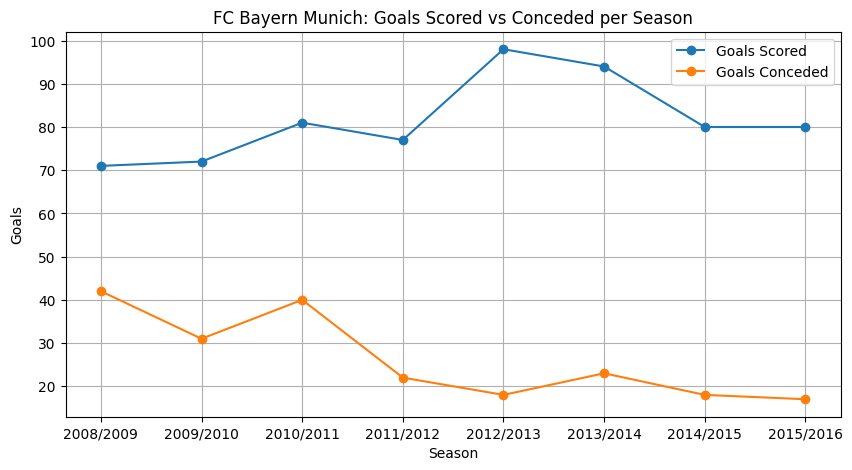

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(bayern_data['season'], bayern_data['goals_scored'], label='Goals Scored', marker='o')
plt.plot(bayern_data['season'], bayern_data['goals_conceded'], label='Goals Conceded', marker='o')
plt.title('FC Bayern Munich: Goals Scored vs Conceded per Season')
plt.xlabel('Season')
plt.ylabel('Goals')
plt.legend()
plt.grid(True)
plt.show()


## Correlation Heatmap

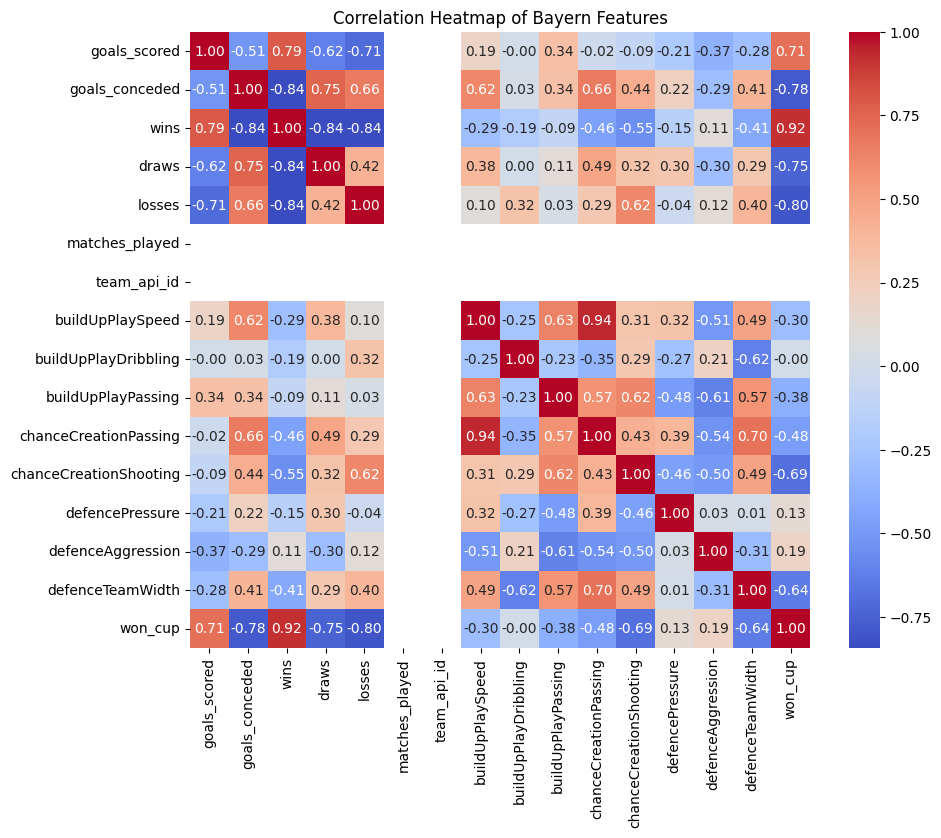

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = bayern_data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Bayern Features')
plt.show()


- **Accuracy:** around 100% (on this small dataset)
- **Most important features:** goals scored, goals conceded, chance creation, and defence stats.
- **Conclusion:** Bayern’s dominance is strongly linked to goal-scoring ability and defensive strength.
